<a href="https://colab.research.google.com/github/sdallman/focus_ml_model/blob/main/Pycaret_Date_time_series_of_pressure.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install --pre pycaret

# Time series forecast of pressure data

In [ ]:
from pycaret.regression import *
# Data manipulation
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Machine learning
from sklearn.metrics import mean_squared_error
import xgboost as xgb

plt.style.use('fivethirtyeight')

In [ ]:
df=pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Focus/pressure-2023-02-10.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21209 entries, 0 to 21208
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   id         21209 non-null  int64 
 1   client     21209 non-null  object
 2   location   21209 non-null  object
 3   device     21209 non-null  object
 4   pressureA  21209 non-null  int64 
 5   pressureB  21209 non-null  int64 
 6   timestamp  21209 non-null  object
dtypes: int64(3), object(4)
memory usage: 1.1+ MB


## Convert the columns with date information into a datetime format

In [ ]:
df['timestamp'] = pd.to_datetime(df['timestamp'])

## Remove data to only have one value per day

In [ ]:
pressureA = df.groupby(df['timestamp'].dt.date)['pressureA'].min().reset_index()
pressureB = df.groupby(df['timestamp'].dt.date)['pressureB'].min().reset_index()

df = pressureA.join(pressureB.set_index('timestamp'), on='timestamp')
df.head()

,timestamp,pressureA,pressureB
0,2020-04-24,1113,2327
1,2020-04-25,1111,2325
2,2020-04-26,1103,2313
3,2020-04-27,1020,2323
4,2020-04-28,924,2329


In [ ]:
# remove values that were from gas leak
low_value = df.query('pressureB< 1500')
df.loc[low_value.index, 'pressureB'] = low_value['pressureB'].map(lambda x: 2170)

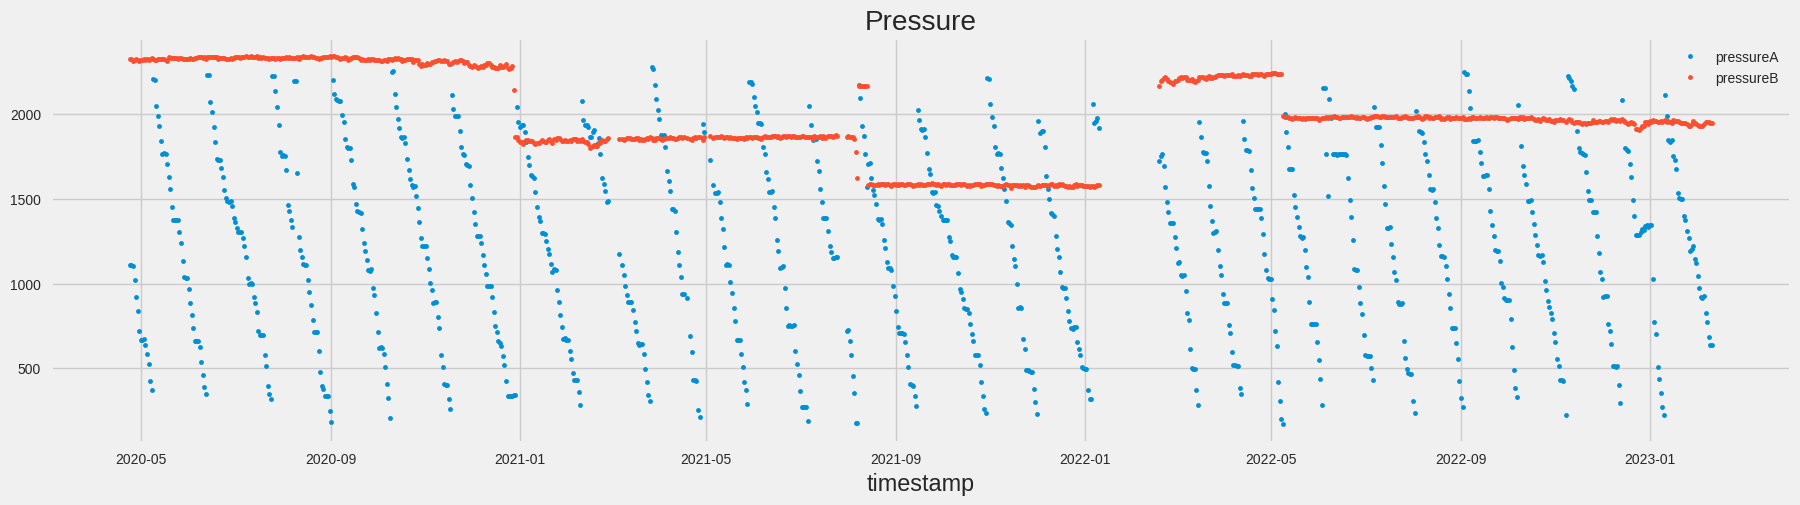

In [ ]:
df.plot(style='.', x='timestamp', figsize=(20,5), title='Pressure')
plt.show()

In [ ]:
#@title Move Timestamp to index
def create_days_until_change(df):
  df['timestamp'] = pd.to_datetime(df['timestamp'])
  df = df.set_index('timestamp')
  df['days'] = 0
  df.sort_index(ascending=False, inplace=True)

  #@title Adding the count of how many days until changed
  count = 0
  A_index = df.columns.get_loc("pressureA")
  B_index = df.columns.get_loc("pressureA")
  day_index = df.columns.get_loc("days")

  for i in range(df.shape[0] - 1):
    df.iloc[i, day_index] = count
    if df.iloc[i, A_index + B_index] > df.iloc[i+1, A_index + B_index]+500:
      df.iloc[i, day_index] = 0
      count = 0
    count += 1
  df.sort_index(ascending=True, inplace=True)
  return df

In [ ]:
df = create_days_until_change(df)

In [ ]:
df.head(100)

,pressureA,pressureB,days
timestamp,,,
2020-04-24,1113,2327,0
2020-04-25,1111,2325,14
2020-04-26,1103,2313,13
2020-04-27,1020,2323,12
2020-04-28,924,2329,11
...,...,...,...
2020-07-28,2041,2333,11
2020-07-29,1940,2331,10
2020-07-30,1778,2330,9


# Feature additions

In [ ]:
def create_features(df):
  """
  Create time series features based on time series index
  """
  df = df.copy()
  #df['month'] = df.index.month
  #df['day'] = df.index.day
  df['day_of_week'] = df.index.day_of_week
  return df


In [ ]:
def create_lags(df):
  """
  Create time series lags for the training data
  """
  df['pressureA_lag1'] = df['pressureA'].shift(1)
  df['pressureB_lag1'] = df['pressureB'].shift(1)
  df['pressureA_lag2'] = df['pressureA'].shift(2)
  df['pressureB_lag2'] = df['pressureB'].shift(2)
  df['pressureA_lag3'] = df['pressureA'].shift(3)
  df['pressureB_lag3'] = df['pressureB'].shift(3)
  return df

In [ ]:
df = create_features(df)
df = create_lags(df)

In [ ]:
filtered_df = df[df['days'] > 40]
filtered_df.head(40)

,pressureA,pressureB,days,day_of_week,pressureA_lag1,pressureB_lag1,pressureA_lag2,pressureB_lag2,pressureA_lag3,pressureB_lag3
timestamp,,,,,,,,,,
2020-06-14,2233,2336,41,6,2234.0,2336.0,351.0,2327.0,389.0,2337.0
2020-11-19,2034,2307,41,3,2115.0,2306.0,259.0,2299.0,321.0,2300.0
2020-12-31,1957,1850,41,3,2045.0,1864.0,345.0,1864.0,341.0,2144.0
2021-09-16,1964,1584,44,3,2027.0,1590.0,275.0,1580.0,334.0,1580.0
2021-09-17,1911,1589,43,4,1964.0,1584.0,2027.0,1590.0,275.0,1580.0
2021-09-18,1908,1583,42,5,1911.0,1589.0,1964.0,1584.0,2027.0,1590.0
2021-09-19,1911,1581,41,6,1908.0,1583.0,1911.0,1589.0,1964.0,1584.0


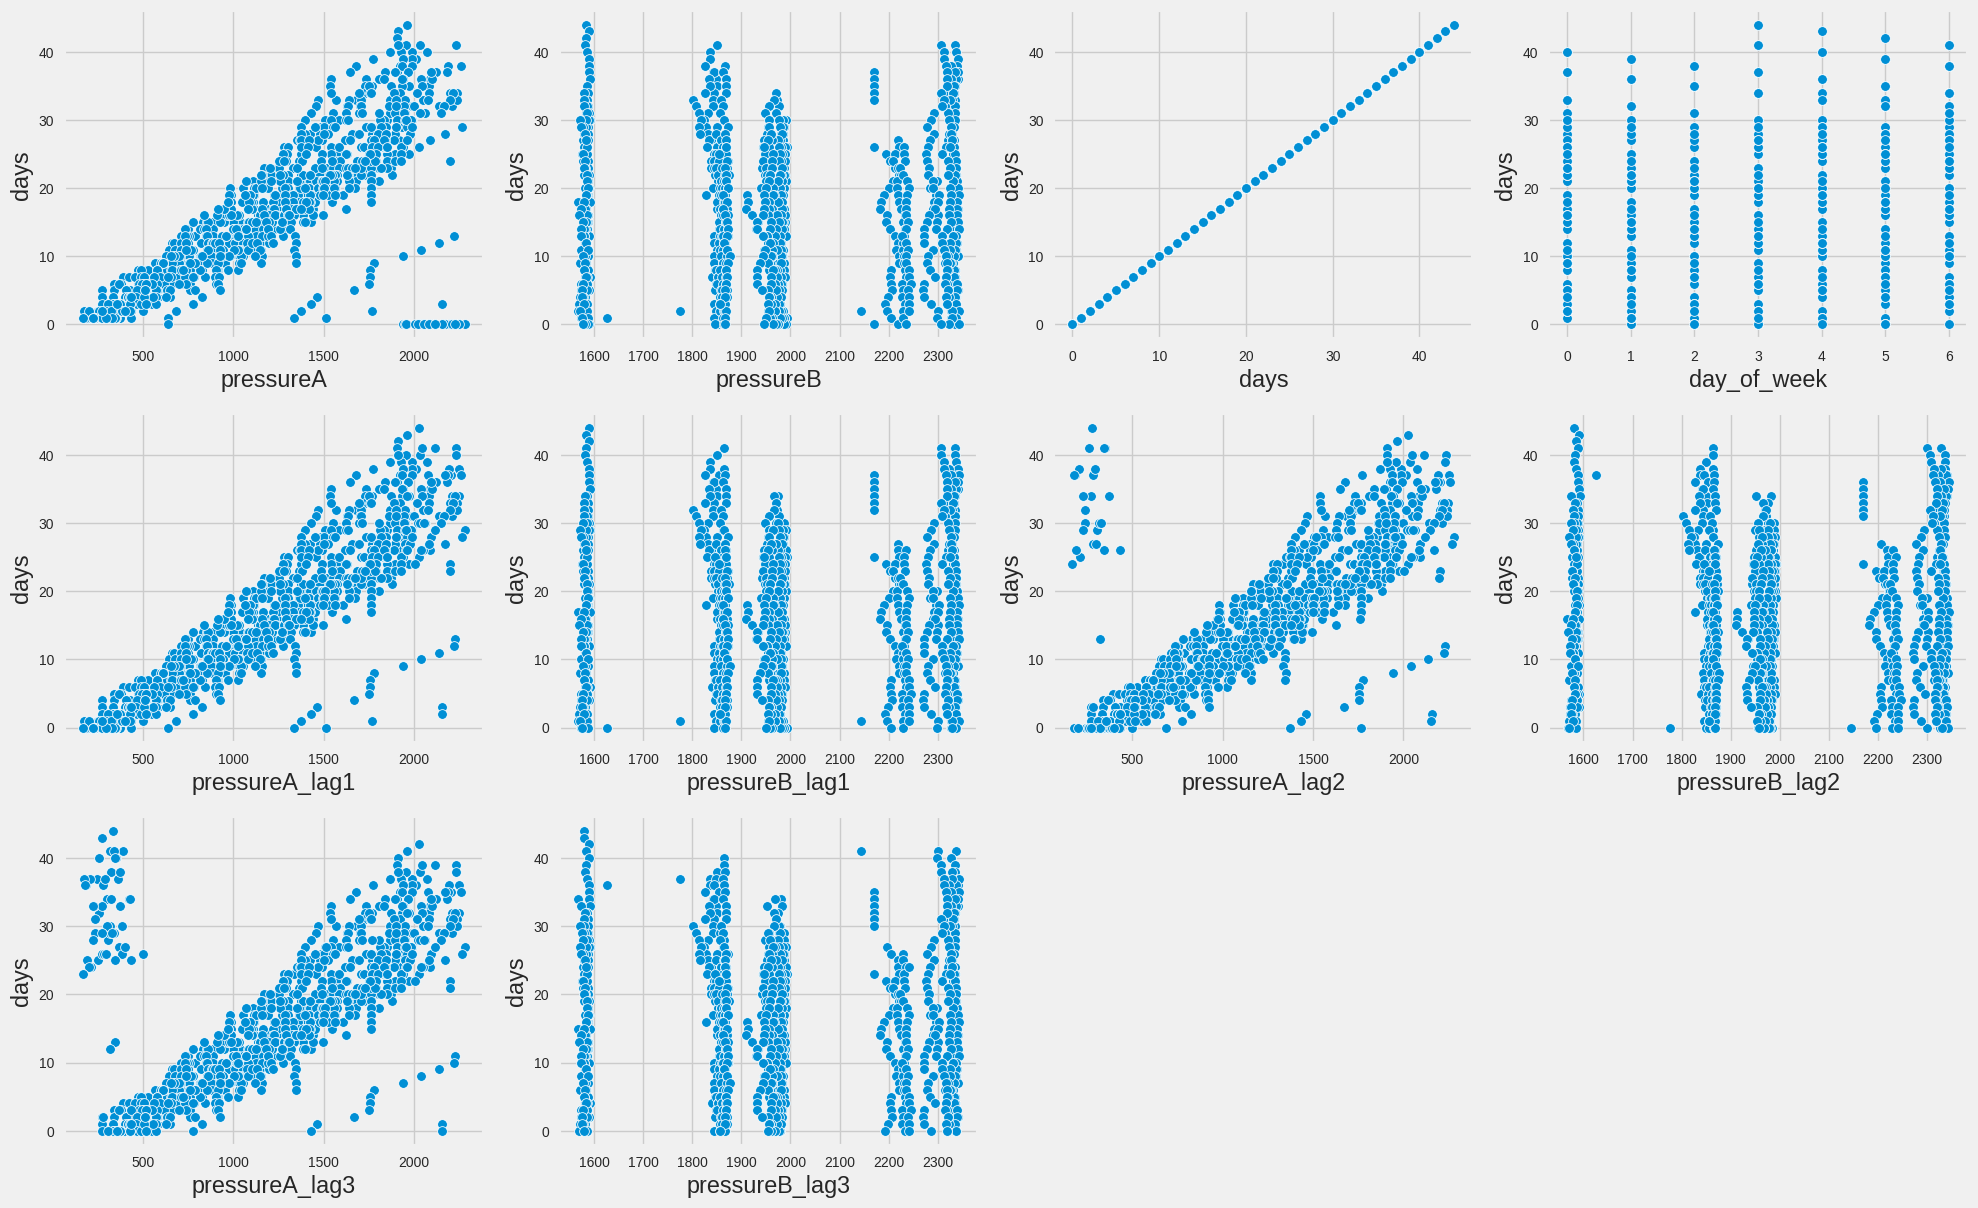

In [ ]:
days = df[['days']]

plt.figure(figsize=(20,40))
for i in range(len(df.columns)):
    plt.subplot(10,4,i+1)
    sns.scatterplot(x=df.iloc[:, i], y='days', data=df.dropna())
plt.tight_layout()
plt.show()

# Make pycaret model

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 965 entries, 2020-04-24 to 2023-02-10
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   pressureA       965 non-null    int64  
 1   pressureB       965 non-null    int64  
 2   days            965 non-null    int64  
 3   day_of_week     965 non-null    int64  
 4   pressureA_lag1  964 non-null    float64
 5   pressureB_lag1  964 non-null    float64
 6   pressureA_lag2  963 non-null    float64
 7   pressureB_lag2  963 non-null    float64
 8   pressureA_lag3  962 non-null    float64
 9   pressureB_lag3  962 non-null    float64
dtypes: float64(6), int64(4)
memory usage: 82.9 KB


In [ ]:
reg = setup(df,
            target='days',
            session_id=123)

,Description,Value
0,Session id,123
1,Target,days
2,Target type,Regression
3,Original data shape,"(965, 10)"
4,Transformed data shape,"(965, 10)"
5,Transformed train set shape,"(675, 10)"
6,Transformed test set shape,"(290, 10)"
7,Numeric features,9
8,Rows with missing values,0.3%
9,Preprocess,True


In [ ]:
best = compare_models()

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
rf,Random Forest Regressor,2.5855,19.8447,4.3306,0.8183,0.3548,0.3183,0.2540
lightgbm,Light Gradient Boosting Machine,2.6929,19.9055,4.3407,0.8156,0.3829,0.3242,0.4230
gbr,Gradient Boosting Regressor,2.7463,20.4660,4.4360,0.8115,0.3953,0.3356,0.1820
et,Extra Trees Regressor,2.6002,21.1298,4.4560,0.8058,0.3495,0.3173,0.2190
xgboost,Extreme Gradient Boosting,2.7245,21.5161,4.5162,0.8014,0.3610,0.3184,0.2390
knn,K Neighbors Regressor,2.9439,23.7659,4.7308,0.7805,0.3650,0.3577,0.2550
huber,Huber Regressor,3.3126,23.8700,4.8075,0.7769,0.4247,0.3829,0.1680
br,Bayesian Ridge,3.3458,24.1658,4.8319,0.7747,0.4275,0.3906,0.1460
lar,Least Angle Regression,3.3558,24.1895,4.8325,0.7746,0.4310,0.3937,0.2330
ridge,Ridge Regression,3.3558,24.1894,4.8325,0.7746,0.4310,0.3937,0.1830


Processing:   0%|          | 0/81 [00:00<?, ?it/s]

In [ ]:
tuned = tune_model(best, optimize = 'MAE')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,2.1917,9.9634,3.1565,0.9158,0.3001,0.1655
1,2.1021,15.9935,3.9992,0.8253,0.3172,0.2437
2,2.5893,21.9525,4.6853,0.7363,0.4760,0.3624
3,2.0903,10.8102,3.2879,0.8996,0.3403,0.4505
4,2.5067,14.1829,3.7660,0.8400,0.3837,0.3335
5,2.7395,20.0824,4.4813,0.8497,0.4719,0.2819
6,2.6556,19.9638,4.4681,0.8207,0.4632,0.1777
7,2.2187,10.0201,3.1655,0.9091,0.2767,0.1726
8,2.7435,18.8372,4.3402,0.8451,0.3345,0.2856


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 10 folds for each of 10 candidates, totalling 100 fits


In [ ]:
predict_model(tuned)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Random Forest Regressor,2.5816,17.0403,4.1280,0.8440,0.3337,0.2595


,pressureA,pressureB,day_of_week,pressureA_lag1,pressureB_lag1,pressureA_lag2,pressureB_lag2,pressureA_lag3,pressureB_lag3,days,prediction_label
timestamp,,,,,,,,,,,
2020-10-12,2120,2334,0,2258.0,2326.0,2250.0,2322.0,207.0,2328.0,37,27.562645
2021-06-01,2101,1868,1,2182.0,1863.0,2189.0,1866.0,2192.0,1865.0,36,30.633173
2020-11-14,402,2316,5,405.0,2320.0,507.0,2315.0,580.0,2316.0,4,3.014468
2022-07-16,1331,1983,5,1331.0,1982.0,1470.0,1986.0,1575.0,1991.0,18,16.187025
2021-04-01,1974,1858,3,2026.0,1862.0,2090.0,1858.0,2172.0,1848.0,25,30.957133
...,...,...,...,...,...,...,...,...,...,...,...
2022-12-05,762,1955,0,925.0,1962.0,926.0,1963.0,924.0,1957.0,9,6.965834
2020-12-23,425,2295,2,519.0,2285.0,570.0,2277.0,629.0,2280.0,7,3.776177
2022-06-25,1078,1979,5,1084.0,1986.0,1258.0,1982.0,1395.0,1988.0,12,13.703975


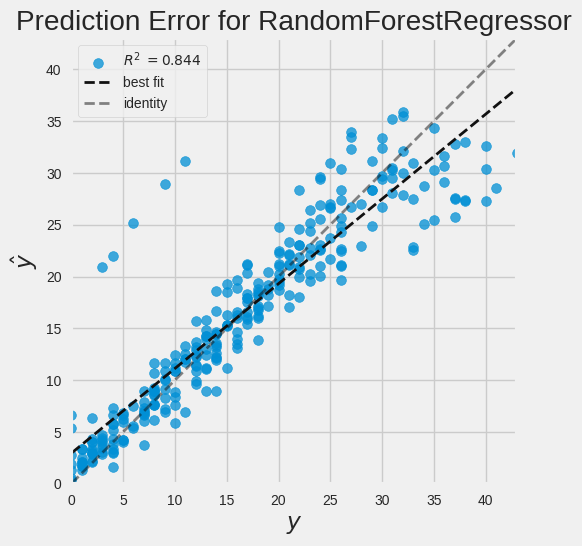

In [ ]:
# plot error
plot_model(tuned, plot = 'error')

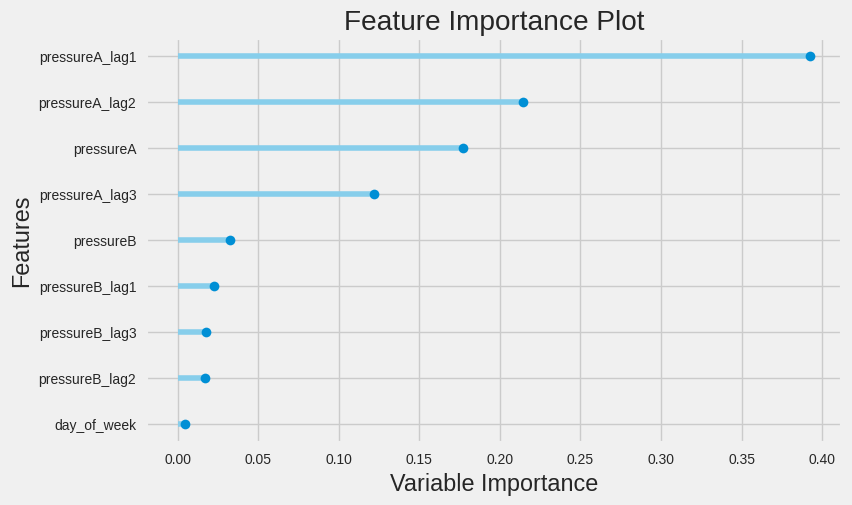

In [ ]:
# plot feature importance
plot_model(tuned, plot = 'feature')

In [ ]:
final = finalize_model(tuned)

# Predict into the future

In [ ]:
#@title Copy last row into new dataframe

data_df = pd.DataFrame(df.iloc[-1,]).T
data_df.drop(['days'], axis=1, inplace=True)
data_df

,pressureA,pressureB,day_of_week,pressureA_lag1,pressureB_lag1,pressureA_lag2,pressureB_lag2,pressureA_lag3,pressureB_lag3
2023-02-10,637.0,1947.0,4.0,638.0,1951.0,685.0,1957.0,775.0,1954.0


In [ ]:
num_periods=1

# Create future dataframe
future_date = pd.date_range(start=data_df.index.min(), periods=num_periods, freq='D')
future_df = pd.DataFrame(index=future_date, columns=['pressureA',	'pressureB', 'day_of_week',	'pressureA_lag1',	'pressureB_lag1', 'pressureA_lag2', 'pressureB_lag2',	'pressureA_lag3', 'pressureB_lag3'])
future_df = future_df.astype(float)
future_df.head()

,pressureA,pressureB,day_of_week,pressureA_lag1,pressureB_lag1,pressureA_lag2,pressureB_lag2,pressureA_lag3,pressureB_lag3
2023-02-10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
# insert data into dataframe
future_df.iloc[0] = data_df.iloc[0]
future_df.head()

,pressureA,pressureB,day_of_week,pressureA_lag1,pressureB_lag1,pressureA_lag2,pressureB_lag2,pressureA_lag3,pressureB_lag3
2023-02-10,637.0,1947.0,4.0,638.0,1951.0,685.0,1957.0,775.0,1954.0


In [ ]:
future_df.T

,2023-02-10
pressureA,637.0
pressureB,1947.0
day_of_week,4.0
pressureA_lag1,638.0
pressureB_lag1,1951.0
pressureA_lag2,685.0
pressureB_lag2,1957.0
pressureA_lag3,775.0
pressureB_lag3,1954.0


In [ ]:
#@title Predict how many days to change

predictions = predict_model(final, data = future_df)
print(predictions)

            pressureA  pressureB  day_of_week  pressureA_lag1  pressureB_lag1  \
2023-02-10      637.0     1947.0          4.0           638.0          1951.0   

            pressureA_lag2  pressureB_lag2  pressureA_lag3  pressureB_lag3  \
2023-02-10           685.0          1957.0           775.0          1954.0   

            prediction_label  
2023-02-10             3.399  


# Save model

In [ ]:
save_model(final, '/content/drive/MyDrive/Colab Notebooks/Focus/pressure_pipeline')

Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=FastMemory(location=/tmp/joblib),
          steps=[('numerical_imputer',
                  TransformerWrapper(include=['pressureA', 'pressureB',
                                              'day_of_week', 'pressureA_lag1',
                                              'pressureB_lag1', 'pressureA_lag2',
                                              'pressureB_lag2', 'pressureA_lag3',
                                              'pressureB_lag3'],
                                     transformer=SimpleImputer())),
                 ('categorical_imputer',
                  TransformerWrapper(include=[],
                                     transformer=SimpleImputer(strategy='most_frequent'))),
                 ('actual_estimator',
                  RandomForestRegressor(bootstrap=False, max_depth=11,
                                        max_features='sqrt',
                                        min_impurity_decrease=0.0002,
                                        